In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
!git config --global credential.helper store

In [3]:
# Logging in to hugging face using tokens
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

2024-07-28 05:59:28.784038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 05:59:28.784137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 05:59:28.906087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.29.2",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [7]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [8]:
# Loading custom dataset
dataset = load_dataset(path="/kaggle/input/skinimages/ddidiversedermatologyimages", split="train")

# Defining parameters for data pre processing
image_size = 256  # @param
batch_size = 6  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# Train dataloader for model training
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Resolving data files:   0%|          | 0/656 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Previewing batch:


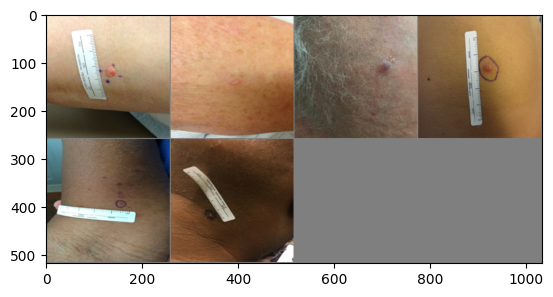

In [9]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

  0%|          | 0/110 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.010806229957167736


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1 average loss: 0.00957827136841264


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2 average loss: 0.007519816785299388


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3 average loss: 0.008609355887694453


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4 average loss: 0.008001900818304751


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5 average loss: 0.00601450980598615


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6 average loss: 0.007603645554627292


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7 average loss: 0.011416907984609927


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8 average loss: 0.010248286677101119


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9 average loss: 0.007296394623831888


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10 average loss: 0.009593176180152858


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 11 average loss: 0.008036407045173374


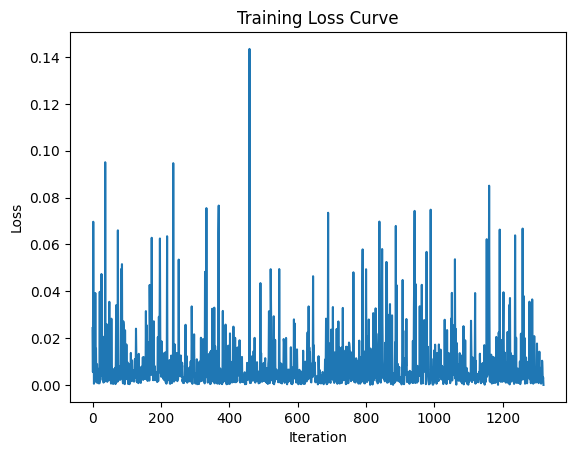

In [10]:
num_epochs = 12  # @param
lr = 1e-5  # @param
grad_accumulation_steps = 2  # @param

# Adjust the learning rate based on the number of gradient accumulation steps
adjusted_lr = lr / grad_accumulation_steps

# Setting the optimization target to the model parameters
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=adjusted_lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(noise_pred, noise)  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Backpropagation with gradient accumulation
        loss.backward()

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Print the average loss for the epoch
    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):]) / len(train_dataloader)}")

# Plot the loss curve:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

0it [00:00, ?it/s]

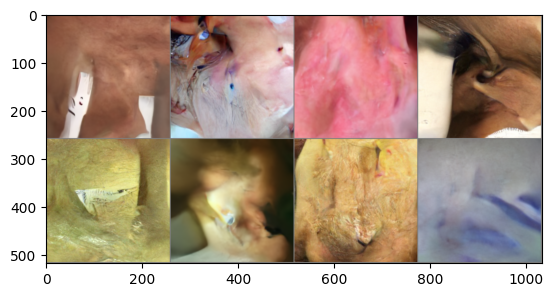

In [11]:
# @markdown Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [12]:
# Utility functions for working with images
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


In [17]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

In [18]:
# Random starting point (8 random images)
sample = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8

# Store intermediate samples for visualization
intermediate_samples = []

for i, t in enumerate(scheduler.timesteps):
    # Get model prediction
    with torch.no_grad():
        residual = image_pipe.unet(sample, t)["sample"]

    # Update sample with step
    sample = scheduler.step(residual, t, sample).prev_sample

    intermediate_samples.append(sample)

In [19]:
len(intermediate_samples)

40

In [ ]:
# Display all intermediate samples
fig, axes = plt.subplots(len(intermediate_samples), 1, figsize=(20, len(intermediate_samples) * 5))
for i, sample in enumerate(intermediate_samples):
    axes[i].imshow(show_images(sample))
    axes[i].axis('off')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()